# Simple stock trading simulator

Realisation and detail descriprion you may show in: 

https://medium.com/@sthanikamsanthosh1994/custom-gym-environment-stock-trading-for-reinforcement-learning-stable-baseline3-629a489d462d 

In [30]:
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO

In [3]:
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        self.MAX_ACCOUNT_BALANCE = 2147483647
        self.MAX_NUM_SHARES = 2147483647
        self.MAX_SHARE_PRICE = 5000
        self.MAX_STEPS = 20000

        self.INITIAL_ACCOUNT_BALANCE = 10000

        self.df = df
        self.reward_range = (0, self.MAX_ACCOUNT_BALANCE)

        # Since our environment is going to return a couple of values, due to this we defined our action_space to hold two values. 
        # One value would lie between 0 and 3 (action type -> Buy, Sell, and Hold), and the other one between 0 and 1 ( percentage of the amount to buy, sell, and hold ).
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float32)

        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(6, 6), dtype=np.float32)

    def _next_observation(self):
        # Get the stock data points for the last 5 days and scale to between 0-1
        frame = np.array([
            self.df.loc[self.current_step: self.current_step +
                        5, 'Open'].values / self.MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'High'].values / self.MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'Low'].values / self.MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'Close'].values / self.MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'Volume'].values / self.MAX_NUM_SHARES
        ])

        # Append additional data and scale each value to between 0-1
        # print(self.current_step)
        # print(frame.shape)
        obs1 = np.append(frame, [[
            self.balance / self.MAX_ACCOUNT_BALANCE,
            self.max_net_worth / self.MAX_ACCOUNT_BALANCE,
            self.shares_held / self.MAX_NUM_SHARES,
            self.cost_basis / self.MAX_SHARE_PRICE,
            self.total_shares_sold / self.MAX_NUM_SHARES,
            self.total_sales_value / (self.MAX_NUM_SHARES * self.MAX_SHARE_PRICE),
        ]], axis=0)
        obs =obs1
        return obs

    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(
            self.df.loc[self.current_step, "Open"], self.df.loc[self.current_step, "Close"])

        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (
                prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)

        self.current_step += 1

        if self.current_step > len(self.df.loc[:, 'Open'].values) - 6:
            self.current_step = 0

        delay_modifier = (self.current_step / self.MAX_STEPS)

        reward = self.balance * delay_modifier
        done = self.net_worth <= 0

        obs = self._next_observation()

        return obs, reward, done, done, {}

    def reset(self, seed=None):
        # Reset the state of the environment to an initial state
        self.balance = self.INITIAL_ACCOUNT_BALANCE
        self.net_worth = self.INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = self.INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(
            0, len(self.df.loc[:, 'Open'].values) - 6)

        return (self._next_observation(), {})

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - self.INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(
            f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(
            f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [4]:
%load_ext tensorboard 
%tensorboard --logdir ./tensorboard_log/

In [5]:
# Clear any logs from previous runs
!rm -rf ./tensorboard_log/

In [18]:
df = pd.read_csv('./data/AAPL.csv')
df = df.sort_values('Date')
df.dropna(inplace=True)
df = df.sort_values('Date')
df = df.reset_index()

# The algorithms require a vectorized environment to run
env = DummyVecEnv([lambda: StockTradingEnv(df)])

/Users/stureiko/miniforge3/envs/otus/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


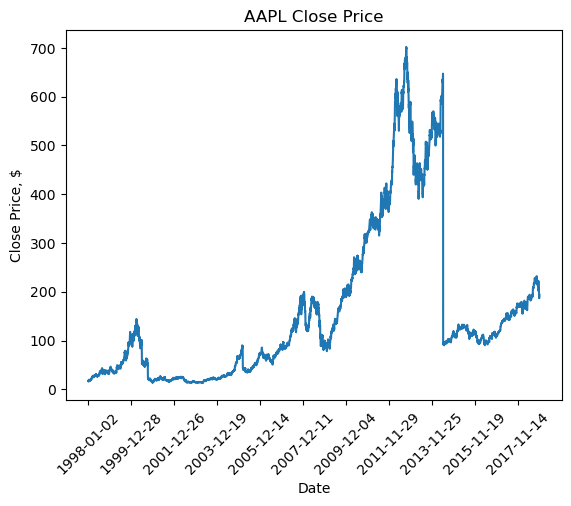

In [26]:
plt.plot(df['Close'], label='AAPL')
ind = np.arange(0, df.shape[0], 500)
labels = [df.loc[i, 'Date'] for i in ind]
plt.xticks(ind, labels, rotation=45)
# plt.legend()
plt.ylabel('Close Price, $')
plt.xlabel('Date')
plt.title('AAPL Close Price')
plt.show()

In [27]:
model = PPO("MlpPolicy", env, verbose=0, tensorboard_log="./tensorboard_log/")
model.learn(total_timesteps=20000, log_interval=1, tb_log_name="PPO_tr", progress_bar=True)

Output()

/var/folders/lk/6f78t4jn60s5_ntqqc2dj0980000gn/T/ipykernel_54789/831962003.py:70: RuntimeWarning: invalid value 
encountered in scalar divide
  self.cost_basis = (

/var/folders/lk/6f78t4jn60s5_ntqqc2dj0980000gn/T/ipykernel_54789/831962003.py:70: RuntimeWarning: invalid value encountered in scalar divide
  self.cost_basis = (


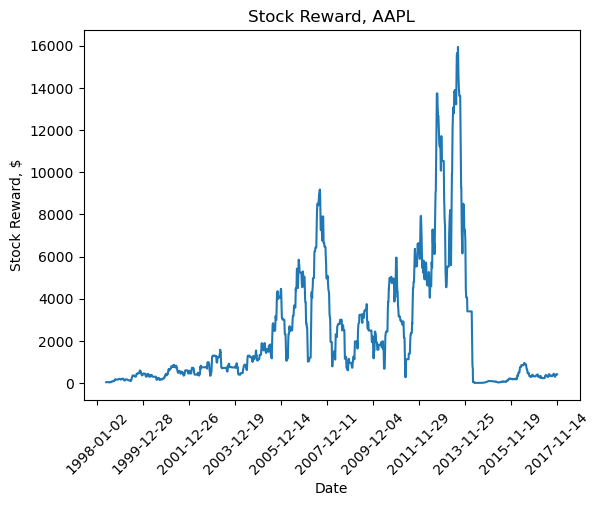

In [28]:
obs = env.reset()
total_reward = []
for i in range(5000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    total_reward.append(rewards[0])
    # print(rewards[0], total_reward[i])

r = pd.DataFrame(total_reward).rolling(window=100).mean()
ind = np.arange(0, df.shape[0], 500)
labels = [df.loc[i, 'Date'] for i in ind]
plt.xticks(ind, labels, rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Reward, $')
plt.title('Stock Reward, AAPL')
plt.plot(r)
plt.show()


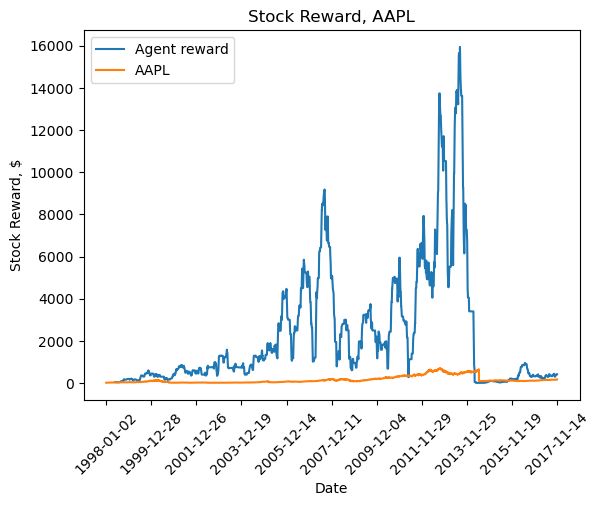

In [29]:
r = pd.DataFrame(total_reward).rolling(window=100).mean()
plt.plot(r, label='Agent reward')
ind = np.arange(0, df.shape[0], 500)
labels = [df.loc[i, 'Date'] for i in ind]
plt.xticks(ind, labels, rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Reward, $')
plt.title('Stock Reward, AAPL')
plt.plot(df['Close'][:5000], label='AAPL')
plt.legend()
plt.show()